# コードベースは YouTube より

https://www.youtube.com/watch?v=NN0A0Cjo2tQ


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import LpMinimize, LpProblem, LpVariable, PULP_CBC_CMD, CPLEX_PY, LpStatus, value, listSolvers


In [2]:
# https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html
# listSolvers()


In [3]:
# la40
with open('data/jssp/la40.txt', 'r') as f:
    la40_data: list = [
        line.rstrip("\n").split("\t")
        for line in f.readlines()
    ]


num_machines, num_jobs = la40_data[0]
processing_time_per_job = la40_data[1:16]
machine_sequence_per_job = la40_data[16:31]

processing_time_per_job = pd.DataFrame(processing_time_per_job).astype(int)
machine_sequence_per_job = pd.DataFrame(machine_sequence_per_job).astype(int)

num_machine = processing_time_per_job.shape[0]  # number of machines
num_job = processing_time_per_job.shape[1]  # number of jobs

# processing_times
processing_times = processing_time_per_job.values.tolist()
#　machine_sequences for tasks
machines = machine_sequence_per_job.values.tolist()


In [4]:
# machines

In [5]:
# Job
jobIds = range(0, len(processing_times))

# Job 内の task
jobTaskIds = range(0, len(processing_times[0]))

M = 10000  # large number
s = {}
x = {}

# model
model = LpProblem(sense = LpMinimize)

# 決定変数
mkspan = LpVariable("mkspan", lowBound=0, upBound=None, cat="Continuous")

for i in jobIds:
    for k in jobTaskIds:
        # 開始時刻
        s[i, k] = LpVariable("s{},{}".format(i,k), lowBound=0, upBound=None, cat="Continuous")

        # 作業 i,k が 作業 j,l よりも先に行われることを示す
        for j in jobIds:
            for l in jobTaskIds:
                if (i != j) & (machines[i][k] == machines[j][l]):
                    x[i, k, j, l] = LpVariable("x{},{},{},{}".format(i,k,j,l), cat="Binary")

# 目的関数
model += mkspan

# Constraints
for i in jobIds:
    for k in jobTaskIds:
        model += mkspan >= s[i,k] + processing_times[i][k]
        model += s[i,k] >= 0

    for k in range(1, len(jobTaskIds) - 1):
        model += s[i, k + 1] >= s[i, k] + processing_times[i][k]

for i in jobIds:
    for k in jobTaskIds:
        for j in jobIds:
            for l in jobTaskIds:
                if (i != j) & (machines[i][k] == machines[j][l]):
                    model += s[j, l] >= s[i, k] + processing_times[i][k] - M * (1 - x[i, k, j, l])
                    model += s[i, k] >= s[j, l] + processing_times[j][l] - M * x[i, k, j, l]
                    model += x[i, k, j, l] + x[j, l, i, k,] == 1


In [ ]:
# 実行
# https://yamakuramun.info/2020/09/27/227/
# https://qiita.com/nariaki3551/items/ea1117afb7f8ffbf7e90
solver = PULP_CBC_CMD(msg=1, threads=8, timeLimit=120)
# solver = PULP_CBC_CMD(msg=1, options=['maxsol 3'], threads=8, timeLimit=300)
# solver = CPLEX_PY(msg=1, threads=8, timeLimit=600)

result = model.solve(solver)
print("status", LpStatus[result])
print("value", value(model.objective))


for i in jobIds:
    for k in jobTaskIds:
        print("Value[s]", s[i, k], value(s[i, k]))

for i in jobIds:
    for k in jobTaskIds:
        for j in jobIds:
            for l in jobTaskIds:
                if (i != j) & (machines[i][k] == machines[j][l]):
                    print("Value[x]", x[i, k, j, l], value(x[i, k, j, l]))


## ソルバーの解を描画

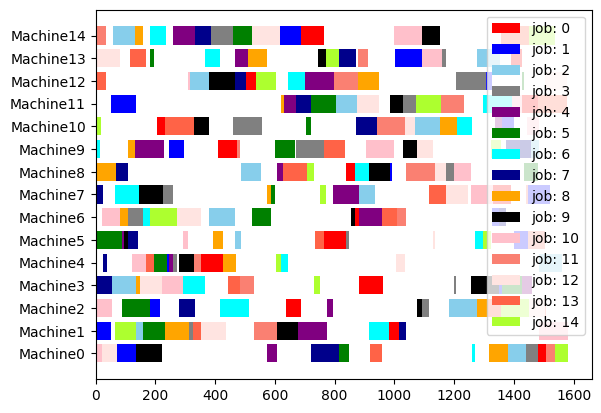

In [7]:
fig, ax = plt.subplots()

# 縦軸の値
machine_name = [
    f"Machine{k}"
    for k in jobTaskIds
]

# 横軸の値
start_time = [0] * len(jobTaskIds)
process_time = [0] * len(jobTaskIds)
# process_time = np.array(finish_time) - np.array(start_time)

colors = [
    "red", "blue", "skyblue", "gray", "purple",
    "green", "cyan", "darkblue", "orange", "black",
    "pink", "salmon", "mistyrose", "tomato", "greenyellow"
]
for i in jobIds:
    color = colors[i]
    for k in jobTaskIds:
        start_time[machines[i][k] - 1] = value(s[i, k])
        process_time[machines[i][k] - 1] = processing_times[i][k]

        # 1回だけ legend 登録用の label を渡す
        if k == 0:
            ax.barh(machine_name, process_time, left = start_time, color=color, label=f"job: {i}")
        else:
            ax.barh(machine_name, process_time, left = start_time, color=color)
        start_time[machines[i][k] - 1] = 0
        process_time[machines[i][k] - 1] = 0

plt.legend()